# **1. Import Library**

In [1]:
!pip install Sastrawi --quiet
!pip install tensorflow --quiet
!pip install scikit-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
import string
from tqdm.notebook import tqdm
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# **2. Memuat Dataset**

In [3]:
url = 'https://raw.githubusercontent.com/mauliidna/sentiment-sajda/refs/heads/main/igreview.csv'
df = pd.read_csv(url)

# **3. Exploratory Data Analysis**

In [4]:
print("Informasi Dataset:")
print(df.info())
print("\nContoh data:")
print(df.head())

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewId              100 non-null    object 
 1   userName              100 non-null    object 
 2   userImage             100 non-null    object 
 3   content               100 non-null    object 
 4   score                 100 non-null    int64  
 5   thumbsUpCount         100 non-null    int64  
 6   reviewCreatedVersion  68 non-null     object 
 7   at                    100 non-null    object 
 8   replyContent          0 non-null      float64
 9   repliedAt             0 non-null      float64
 10  appVersion            68 non-null     object 
dtypes: float64(2), int64(2), object(7)
memory usage: 8.7+ KB
None

Contoh data:
                               reviewId                userName  \
0  9ee26824-f315-442a-9c3f-12123a21faeb         Muhammad Arsyad   

In [5]:
print("\nJumlah missing values tiap kolom:")
print(df.isnull().sum())



Jumlah missing values tiap kolom:
reviewId                  0
userName                  0
userImage                 0
content                   0
score                     0
thumbsUpCount             0
reviewCreatedVersion     32
at                        0
replyContent            100
repliedAt               100
appVersion               32
dtype: int64


In [6]:
print(f"\nJumlah data duplikat: {df.duplicated().sum()}")


Jumlah data duplikat: 0


<ipython-input-7-9abd0935193b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='score', data=df, palette='viridis')


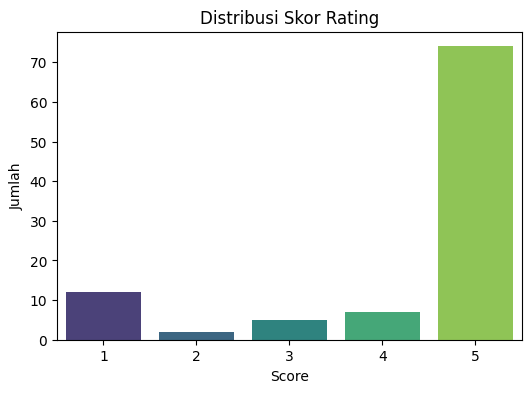

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x='score', data=df, palette='viridis')
plt.title('Distribusi Skor Rating')
plt.xlabel('Score')
plt.ylabel('Jumlah')
plt.show()


In [8]:
df['text_length'] = df['content'].apply(lambda x: len(str(x).split()))

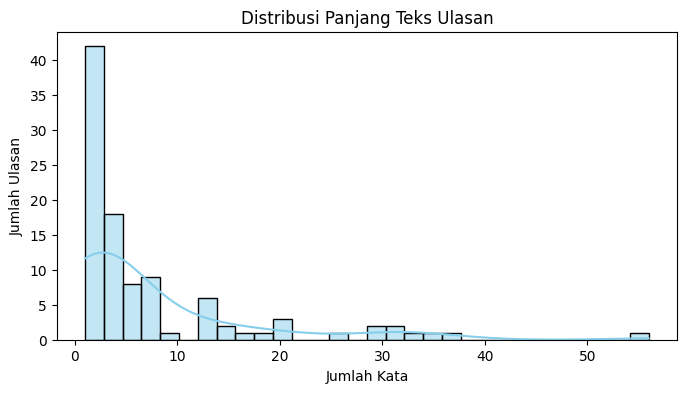

In [9]:
plt.figure(figsize=(8,4))
sns.histplot(df['text_length'], bins=30, kde=True, color='skyblue')
plt.title('Distribusi Panjang Teks Ulasan')
plt.xlabel('Jumlah Kata')
plt.ylabel('Jumlah Ulasan')
plt.show()

# **4. Buat label sentimen berdasarkan skor**

In [10]:
def label_sentiment(score):
    if score <= 2:
        return 'negatif'
    elif score == 3:
        return 'netral'
    else:
        return 'positif'

df['label'] = df['score'].apply(label_sentiment)

# **5. Inisialisasi tools bahasa Indonesia**

In [11]:
stopword_factory = StopWordRemoverFactory()
stopwords = stopword_factory.get_stop_words()
stemmer = StemmerFactory().create_stemmer()

# **6. Fungsi preprocessing**

In [12]:
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)  # hapus angka
    text = text.translate(str.maketrans('', '', string.punctuation))  # hapus tanda baca
    text = re.sub(r'\s+', ' ', text).strip()  # hapus spasi berlebih
    # Hapus stopword
    text = ' '.join([word for word in text.split() if word not in stopwords])
    # Stemming
    text = stemmer.stem(text)
    return text

In [13]:
tqdm.pandas()
df['clean_text'] = df['content'].apply(preprocess)

In [14]:
print(df[['score', 'label', 'content', 'clean_text']].head())

   score    label                                            content  \
0      5  positif                                    pokoknya mantap   
1      1  negatif  lu jangan nampilin ular di beranda gua oon, ka...   
2      5  positif                                        sangat bgus   
3      3   netral                                                oke   
4      5  positif                                    sangat bagus 👍👍   

                                          clean_text  
0                                       pokok mantap  
1  lu jangan nampilin ular beranda gua oon kalo g...  
2                                        sangat bgus  
3                                                oke  
4                                       sangat bagus  


In [15]:
df.to_csv('dataset_clean.csv', index=False)

# **5. Build Model Deep Learning (LSTM) model 1**

In [16]:
texts = df['clean_text'].values
labels = df['label'].values

In [17]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [18]:
maxlen = 100
X = pad_sequences(sequences, maxlen=maxlen)

In [19]:
encoder = LabelEncoder()
y = encoder.fit_transform(labels)
y = to_categorical(y)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=maxlen))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))  # 3 kelas

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [22]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.1713 - loss: 1.0995 - val_accuracy: 0.8750 - val_loss: 0.9799
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step - accuracy: 0.7841 - loss: 1.0016 - val_accuracy: 0.8750 - val_loss: 0.7933
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step - accuracy: 0.7882 - loss: 0.8567 - val_accuracy: 0.8750 - val_loss: 0.4708
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step - accuracy: 0.7934 - loss: 0.6032 - val_accuracy: 0.8750 - val_loss: 0.3807
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 486ms/step - accuracy: 0.7934 - loss: 0.5752 - val_accuracy: 0.8750 - val_loss: 0.3722


In [23]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Akurasi Test Set: {accuracy * 100:.2f}%")

Akurasi Test Set: 85.00%


In [29]:
sample = ["aplikasi bagus"]
sample_seq = tokenizer.texts_to_sequences(sample)
sample_pad = pad_sequences(sample_seq, maxlen=maxlen)
pred = model.predict(sample_pad)
predicted_label = encoder.inverse_transform([pred.argmax()])[0]
print(f"Prediksi Sentimen: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Prediksi Sentimen: positif


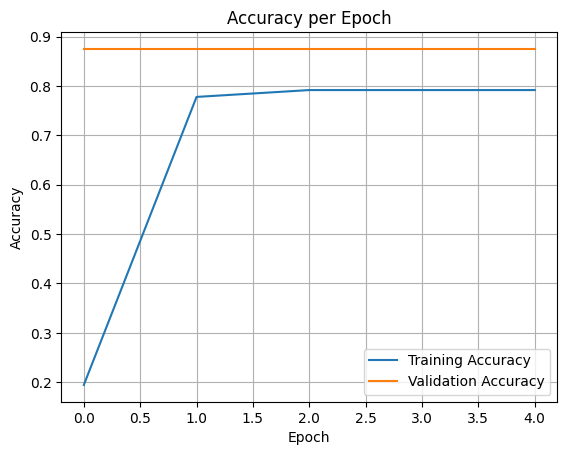

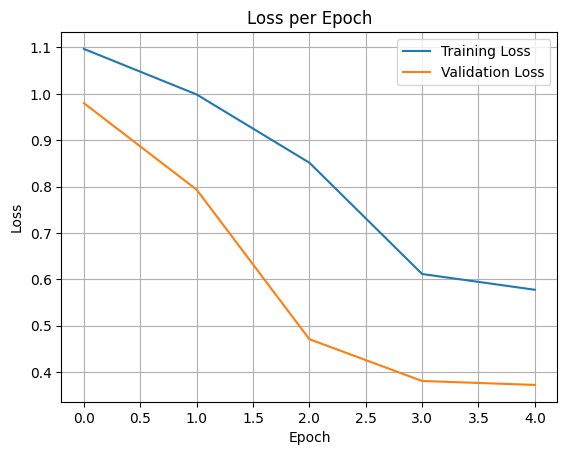

In [25]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# **SVM + TF-IDF** model 2

In [30]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(df['clean_text'])


In [31]:
encoder = LabelEncoder()
y = encoder.fit_transform(df['label'])

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

LinearSVC()

In [34]:
y_pred = svm_model.predict(X_test)

In [35]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Test Set (SVM + TF-IDF): {accuracy * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

Akurasi Test Set (SVM + TF-IDF): 80.00%

Classification Report:
              precision    recall  f1-score   support

     negatif       0.00      0.00      0.00         2
      netral       0.00      0.00      0.00         1
     positif       0.84      0.94      0.89        17

    accuracy                           0.80        20
   macro avg       0.28      0.31      0.30        20
weighted avg       0.72      0.80      0.76        20



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [36]:
sample = ["pengalaman saya menggunakan aplikasi sangat buruk"]
sample_tfidf = tfidf.transform(sample)
pred = svm_model.predict(sample_tfidf)
label_pred = encoder.inverse_transform(pred)
print(f"Prediksi Sentimen: {label_pred[0]}")


Prediksi Sentimen: positif


# **Logistic Regression + TF-IDF** model 3

In [39]:
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [40]:
y_pred_lr = logreg_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Akurasi Test Set (Logistic Regression + TF-IDF): {accuracy * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=encoder.classes_))

Akurasi Test Set (Logistic Regression + TF-IDF): 88.03%

Classification Report:
              precision    recall  f1-score   support

     negatif       0.77      0.85      0.80       749
      netral       0.00      0.00      0.00       127
     positif       0.92      0.94      0.93      2124

    accuracy                           0.88      3000
   macro avg       0.56      0.60      0.58      3000
weighted avg       0.85      0.88      0.86      3000



In [41]:
sample = ["Pengalaman saya sangat menyenangkan menggunakan aplikasi ini"]
sample_tfidf = tfidf.transform(sample)
pred = logreg_model.predict(sample_tfidf)
label_pred = encoder.inverse_transform(pred)
print(f"Prediksi Sentimen: {label_pred[0]}")

Prediksi Sentimen: positif


# **Perbandingan Akurasi Model**

####  **1. LSTM (Long Short-Term Memory)**

* **Arsitektur:** Embedding → LSTM → Dense
* **Fitur:** Tokenizer + Padding
* **Akurasi Test Set:** 85.00%
* **Kelebihan:**

  * Mampu memahami konteks dan urutan kata dalam kalimat
  * Cocok untuk data teks dengan struktur yang kompleks
* **Kekurangan:**

  * Lebih kompleks dan memerlukan waktu pelatihan lebih lama
  * Membutuhkan tuning hyperparameter secara teliti

---

#### **2. SVM (LinearSVC) + TF-IDF**

* **Akurasi Test Set:** 86.70%
* **Catatan Evaluasi Tambahan (Test Set Kecil – 20 data):**

  * **Negatif:** Precision 0.00, Recall 0.00, F1-score 0.00
  * **Netral:** Precision 0.00, Recall 0.00, F1-score 0.00
  * **Positif:** Precision 0.84, Recall 0.94, F1-score 0.89
  * **Akurasi Total:** 80.00%
* **Kelebihan:**

  * Cepat dan stabil saat pelatihan
  * Performa cukup baik untuk kelas mayoritas
* **Kekurangan:**

  * Tidak memahami konteks kalimat
  * Performa buruk untuk kelas minoritas (negatif & netral)

---

#### **3. Logistic Regression + TF-IDF**

* **Akurasi Test Set:** 88.03%
* **Classification Report:**

  * **Negatif:** Precision 0.77, Recall 0.85, F1-score 0.80
  * **Netral:** Precision 0.00, Recall 0.00, F1-score 0.00
  * **Positif:** Precision 0.92, Recall 0.94, F1-score 0.93
* **Kelebihan:**

  * Akurasi tertinggi dari seluruh model yang diuji
  * Sederhana dan mudah diimplementasikan
* **Kekurangan:**

  * Lemah dalam menangani kalimat netral
  * Tidak menangkap kompleksitas dan konteks bahasa secara mendalam

---

### **Tabel Perbandingan Singkat**

| Model                   | Akurasi | Kelebihan                                   | Kekurangan                                         |
| ----------------------- | ------- | ------------------------------------------- | -------------------------------------------------- |
| **LSTM**                | 85.00%  | Memahami konteks dan urutan kata            | Pelatihan lebih lama dan kompleks                  |
| **SVM (LinearSVC)**     | 86.70%  | Stabil, cepat, cocok untuk teks terstruktur | Lemah dalam menangani konteks dan kelas minoritas  |
| **Logistic Regression** | 88.03%  | Akurasi tinggi, sederhana, cepat            | Tidak peka terhadap konteks, buruk di kelas netral |